In [1]:
from Ellipsoidal_layer_V5 import EllipsoidLayer
from NSphere import NSphereNN
from sklearn.metrics import accuracy_score
import plotly
import plotly.graph_objs as go
import pandas as pd
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

### Datasets

In [2]:
from numpy import pi
# import matplotlib.pyplot as plt


def generate_spiral(seeds):
    np.random.seed(seeds)
    N = 300
    theta = np.sqrt(np.random.rand(N,))*4*pi + 2*np.random.randn(N,)  # np.linspace(0,4*pi,100)
    theta_offset = np.random.randn()

    r_a = (2*theta  + pi)
    data_a = np.array([np.cos(theta+theta_offset)*r_a, np.sin(theta+theta_offset)*r_a, 4*r_a +np.random.randn(N,)]).T
    x_a = data_a + 1*np.random.randn(N,3)

    r_b =(-2*theta - pi)
    data_b = np.array([np.cos(theta+theta_offset)*r_b, np.sin(theta+theta_offset)*r_b, -4*r_b+np.random.randn(N,)]).T
    x_b = data_b +  1*np.random.randn(N,3)
    df1 = pd.DataFrame(x_a,columns = ['x','y','z'])
    df2 = pd.DataFrame(x_b,columns = ['x','y','z'])

    df1['label'] = 0
    df2['label'] = 1

    df = pd.concat([df1, df2], ignore_index=True)
    X = df.drop(columns= 'label')

    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    x_scaled = min_max_scaler.fit_transform(X.values)
    X = pd.DataFrame(x_scaled)

    y = df['label']
    return X,y


In [3]:
X,y = generate_spiral(1)

In [4]:
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
    yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
    margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
)

fig = go.Figure(
                layout = layout
                )

fig.add_trace(go.Scatter3d(x=X[y == 0].iloc[:,0], y = X[y == 0].iloc[:,1], z = X[y == 0].iloc[:,2],
                            mode = 'markers',
                            name = 'centers',
                            opacity=1,
                            marker_color = 'red'))

fig.add_trace(go.Scatter3d(x=X[y == 1].iloc[:,0], y = X[y == 1].iloc[:,1], z = X[y == 1].iloc[:,2],
                            mode = 'markers',
                            name = 'centers',
                            opacity=1,
                            marker_color = 'blue'))
fig.update_layout(
    scene=dict(
        xaxis=dict(title='',showticklabels=False),
        yaxis=dict(title='',showticklabels=False),
        zaxis=dict(title='',showticklabels=False),
    )
)
fig.update_layout(showlegend=False)
fig.show()

# Data Preprocessing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

# Unwrapper

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
unwrapper = EllipsoidLayer(n_components=40, max_weight_ratio = 10,max_iter = 1,random_state=1)

In [8]:
unwrapper.fit(X_train,y_train)

j = 1
Cluster Creation finished at: 1.935659646987915
Weight generation finised at: 1.0315461158752441
Bias generation finished at: 1.5933403968811035
Cluster Label indexing finished at: 0.0
Uncovered points =  2
All points covered


Number of ellipsoid neurons built

In [9]:
a = unwrapper.layer_1.centers.shape[0]
print(a)

80


Transform the original X

In [10]:
from Ellipsoidal_layer_V5 import ellipsoid_transform

ModuleNotFoundError: No module named 'Functions'

In [ ]:
X_train_unwrapped = ellipsoid_transform(X_train, unwrapper.layer_1)
X_test_unwrapped = ellipsoid_transform(X_test, unwrapper.layer_1)

In [ ]:
X_train_unwrapped.shape

(450, 80)

In [ ]:
X_test_unwrapped.shape

(150, 80)

Renormalized the unwrapped data

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_scaled = min_max_scaler.fit_transform(X_train_unwrapped)
X_train_unwrapped = pd.DataFrame(x_scaled)

x_scaled = min_max_scaler.fit_transform(X_test_unwrapped)
X_test_unwrapped = pd.DataFrame(x_scaled)

# SNN as unwrapper

In [ ]:
SNN_unwrapper = NSphereNN()
SNN_unwrapper.fit(X_train,y_train)

In [ ]:
from NSphere import first_layer_transform, getw_transform

In [ ]:
X_train_SNN = getw_transform(X_train,SNN_unwrapper.d)
X_test_SNN  = getw_transform(X_test,SNN_unwrapper.d)

In [ ]:
X_train_SNN_unwrapped = first_layer_transform(X_train_SNN,SNN_unwrapper.layer_1)
X_test_SNN_unwrapped = first_layer_transform(X_test_SNN,SNN_unwrapper.layer_1)

In [ ]:
x_scaled = min_max_scaler.fit_transform(X_train_SNN_unwrapped)
X_train_SNN_unwrapped = pd.DataFrame(x_scaled)

x_scaled = min_max_scaler.fit_transform(X_test_SNN_unwrapped )
X_test_SNN_unwrapped  = pd.DataFrame(x_scaled)

# Tensorflow setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

My tensorflow is CPU based (install on Anaconda environment without CUDA)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12939383755988843807
xla_global_id: -1
]


Currently the system automatically pick an appropriate optimum number of threads for parallel operations:

In [ ]:
tf.config.threading.set_inter_op_parallelism_threads(0)
tf.config.threading.set_intra_op_parallelism_threads(0)

In [ ]:
tf.config.threading.get_inter_op_parallelism_threads()

0

In [ ]:
tf.config.threading.get_intra_op_parallelism_threads()

0

In [ ]:
 # format for tensor flow output
y_train = tf.keras.utils.to_categorical(y_train)

In [ ]:
def get_model_MP_1(X):
    model = Sequential([
        keras.layers.Input(shape=(X.shape[1],)),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer='adam', 
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

    return model

In [ ]:
X_train_unwrapped, X_val, y_train_1, y_val = train_test_split(X_train_unwrapped, y_train, test_size=0.2, random_state = 0)

In [ ]:
X_train_unwrapped.shape[1]

80

In [ ]:
model_1 = get_model_MP_1(X_train_unwrapped)

In [ ]:
history_1 = model_1.fit(X_train_unwrapped,y_train_1, epochs = 500, validation_data=(X_val, y_val), verbose=0)

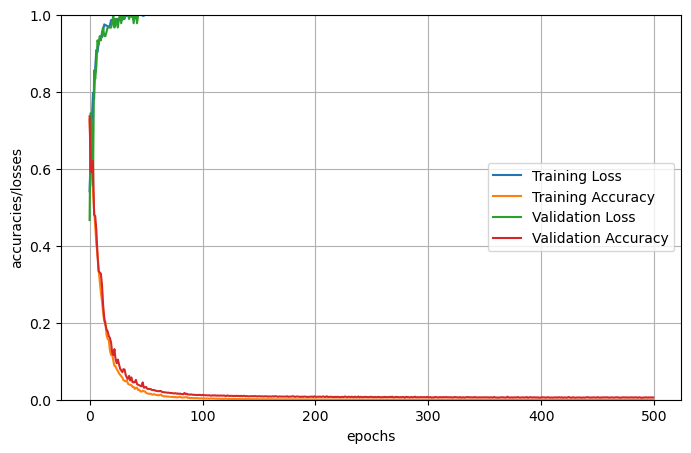

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('epochs')
plt.ylabel('accuracies/losses')
plt.legend(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'],loc='center right')
plt.savefig('ENNMP.pdf',bbox_inches='tight')  
plt.show()

tf.keras.backend.clear_session()

In [ ]:
def get_model_MP_2():
    model = Sequential([
        keras.layers.Input(shape=X.shape[1:]),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer='adam', 
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

    return model

In [ ]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 0)

In [ ]:
model_2 = get_model_MP_2()

In [ ]:
history_2 = model_2.fit(X_train_1,y_train_1, epochs = 500, validation_data=(X_val, y_val), verbose=0)


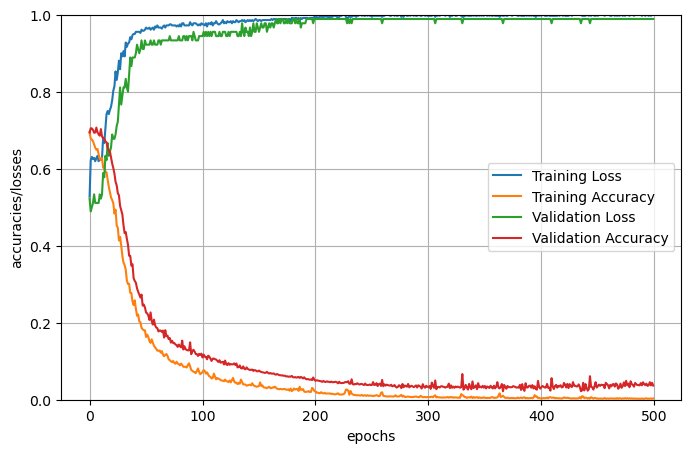

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('epochs')
plt.ylabel('accuracies/losses')
plt.legend(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'],loc='center right')
plt.savefig('MPMP.pdf',bbox_inches='tight')  
plt.show()

tf.keras.backend.clear_session()

In [ ]:
model_3 = get_model_MP_1(X_train_SNN_unwrapped)

In [ ]:
X_train_SNN_unwrapped, X_val, y_train_1, y_val = train_test_split(X_train_SNN_unwrapped, y_train, test_size=0.2, random_state = 0)

In [ ]:
history_3 = model_3.fit(X_train_SNN_unwrapped,y_train_1, epochs = 500, validation_data=(X_val, y_val), verbose=0)

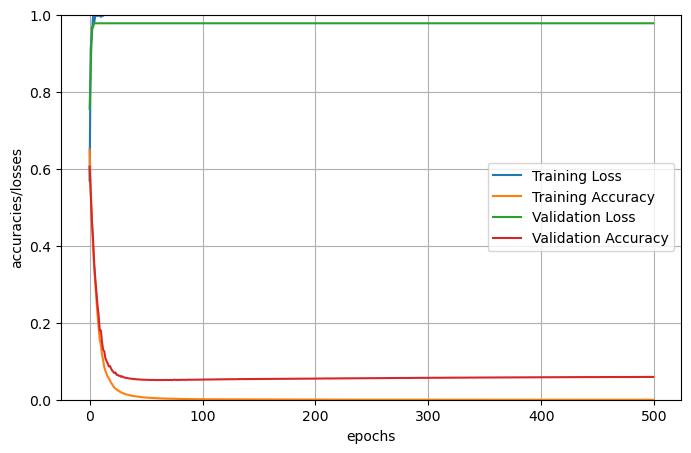

In [ ]:
pd.DataFrame(history_3.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('epochs')
plt.ylabel('accuracies/losses')
plt.legend(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'],loc='center right')
plt.savefig('SNNMP.pdf',bbox_inches='tight')  
plt.show()

tf.keras.backend.clear_session()

## RBF+MP

In [ ]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [ ]:
def get_model_RBF_MP():
    model = Sequential()
    model.add(keras.layers.Input(shape=X.shape[1:]))
    model.add(RBFLayer(100,3))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam', 
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy'])

    return model

In [ ]:
model_4 = get_model_RBF_MP()

AttributeError: module 'keras.backend' has no attribute 'cast_to_floatx'

In [ ]:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 0)

In [ ]:
history_4 = model_4.fit(X_train_1,y_train_1, epochs = 500, validation_data=(X_val, y_val), verbose=0)

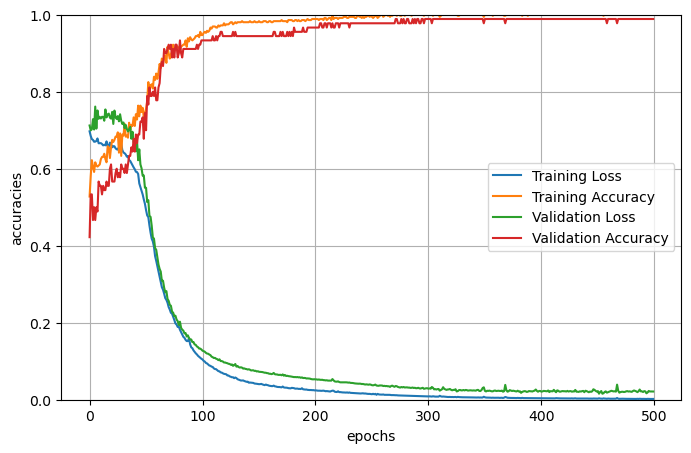

In [ ]:
pd.DataFrame(history_4.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('epochs')
plt.ylabel('accuracies/losses')
plt.legend(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'],loc='center right')
plt.savefig('RBFMP.pdf',bbox_inches='tight')  
plt.show()

tf.keras.backend.clear_session()

# Plot figures

In [ ]:
history = [pd.DataFrame(history_2.history),pd.DataFrame(history_4.history),pd.DataFrame(history_1.history),pd.DataFrame(history_3.history)]
name = ['M-P(s)',
        'RBF+M-P',
        'ENN+M-P',
        'SNN+M-P'
        ]

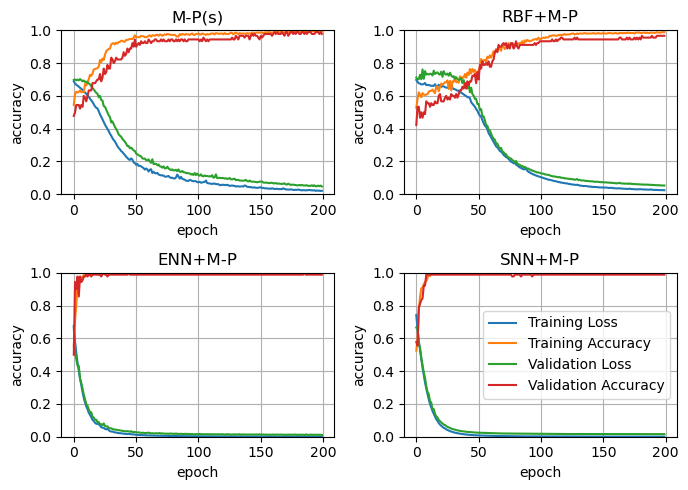

In [ ]:
figure = plt.figure(figsize=(7, 5))

if True:
    for i in range(4):
     
        ax = plt.subplot(2,2,i+1)
        ax.plot(history[i].head(200))
        ax.grid(True)
        ax.set_ylim(0, 1)
        ax.set_title(name[i])
        ax.set_ylabel('accuracy')
        ax.set_xlabel('epoch')

    plt.tight_layout()
    plt.legend(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'],loc='center right')
    plt.savefig('efficiency.pdf',bbox_inches='tight')  
    plt.show()


In [ ]:
model_1.evaluate(X_test_unwrapped, tf.keras.utils.to_categorical(y_test), verbose=0)[1]

0.9800000190734863

In [ ]:
model_2.evaluate(X_test, tf.keras.utils.to_categorical(y_test), verbose=0)[1]

0.9666666388511658

In [ ]:
model_3.evaluate(X_test_SNN_unwrapped, tf.keras.utils.to_categorical(y_test), verbose=0)[1]

0.9800000190734863

In [ ]:
model_4.evaluate(X_test, tf.keras.utils.to_categorical(y_test), verbose=0)[1]

0.9800000190734863

# Repeat the Experiment

Define the unwrapper layer

In [ ]:
def unwrapper_layer(coverage_NN,X_train,y_train,X_test):
    unwrapper = coverage_NN # define the unwrapper

    unwrapper.fit(X_train,y_train)

    if type(unwrapper) == type(NSphereNN()):
        # for the SNN, one need to first transform the input
        X_train = getw_transform(X_train,unwrapper.d)
        X_test  = getw_transform(X_test,unwrapper.d)


        # unwrap the data with Heaviside activation function
        X_train_unwrapped = first_layer_transform(X_train,unwrapper.layer_1)
        X_test_unwrapped = first_layer_transform(X_test,unwrapper.layer_1)

    else:
        # unwrap the data with RELU activation function
        X_train_unwrapped = ellipsoid_transform_3(X_train, unwrapper.layer_1)
        X_test_unwrapped = ellipsoid_transform_3(X_test, unwrapper.layer_1)

    # rescale the input for the next traditional NN layers
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    x_scaled = min_max_scaler.fit_transform(X_train_unwrapped)
    X_train_unwrapped = pd.DataFrame(x_scaled)

    x_scaled = min_max_scaler.fit_transform(X_test_unwrapped)
    X_test_unwrapped = pd.DataFrame(x_scaled)
    return X_train_unwrapped,X_test_unwrapped
    

Set the number of repeated experiment

In [ ]:
n = 1

Generate the fixed seeds

In [ ]:
seeds = np.linspace(0,5000,n, dtype = int)
print(np.unique(seeds).size)

200


Code for performing the test.

In [ ]:
def perform_test(m,n_iteration,seeds,coverage_NN = None):
    accuracies_data = []

    for i in range(n_iteration):
        X,y = generate_spiral(seeds[i]) # generate the data

        # split the train/test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = seeds[i])
        
        if coverage_NN != None:
            # unwrapper + MP
            X_train,X_test = unwrapper_layer(coverage_NN,X_train,y_train,X_test)
            model = m(X_train)

        else: 
            # traditional NNs
            model = m()

        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)

        # split the train/validation set
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = seeds[i])
        model.fit(X_train,y_train, epochs = 300, validation_data=(X_val, y_val), verbose=0)

        accuracies_data.append(model.evaluate(X_test, y_test, verbose=0)[1])

    print('accuracy:',np.mean(accuracies_data))
    print('sd:',np.std(accuracies_data))
    print('se:',np.std(accuracies_data)/np.sqrt(n_iteration))

    return accuracies_data
    

ENN+MP (alpha = 0)

In [ ]:
_ = perform_test(get_model_MP_1,n,seeds,
             coverage_NN = EllipsoidNN(weight_concentration_prior = 1000, n_components=40, 
                                                                 max_weight_ratio = 10,max_iter = 3, clustering_method='hybrid', alpha = 0.))

tf.keras.backend.clear_session()

accuracy: 0.9846000072360038
sd: 0.011988701242198384
se: 0.0008477291945978063


SNN+MP

In [ ]:
_ = perform_test(get_model_MP_1,n,seeds,
             coverage_NN = NSphereNN())

tf.keras.backend.clear_session()

accuracy: 0.9577333298325539
sd: 0.021524559212985784
se: 0.0015220161781553624


MP+MP

In [ ]:
_ = perform_test(get_model_MP_2,n,seeds)

tf.keras.backend.clear_session()

accuracy: 0.9854333406686783
sd: 0.012294128549948978
se: 0.0008693261666448058


RBF+MP

In [ ]:
_ = perform_test(get_model_RBF_MP,n,seeds)

tf.keras.backend.clear_session()

accuracy: 0.98656667470932
sd: 0.010882759394568875
se: 0.0007695272965921257


ENN+MP (alpha = 0.1)

In [ ]:
_ = perform_test(get_model_MP_1,n,seeds,
             coverage_NN = EllipsoidNN(weight_concentration_prior = 1000, n_components=40, 
                                                                 max_weight_ratio = 10,max_iter = 3, clustering_method='hybrid', alpha = 0.1))

tf.keras.backend.clear_session()

accuracy: 0.9839666733145713
sd: 0.012330588868471354
se: 0.0008719043004919452


ENN+MP (alpha = 0.5)

In [ ]:
_ = perform_test(get_model_MP_1,n,seeds,
             coverage_NN = EllipsoidNN(weight_concentration_prior = 1000, n_components=40, 
                                                                 max_weight_ratio = 10,max_iter = 3, clustering_method='hybrid', alpha = 0.5))

tf.keras.backend.clear_session()

accuracy: 0.9877000087499619
sd: 0.010458327552956517
se: 0.0007395154332565665
